# 3. Инженерия признаков для датасета Titanic

In [38]:
# Библиотеки используемые для анализа данных:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для обучении ии-модели 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 3.1 Создание новых признаков на основе существующих

In [18]:
# Загрузка и сохранение датасета в переменную:
df = pd.read_csv('./datasets/eda_titanic_dataset.csv')

# Отображение данных:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Для улучшения качества модели из исходных данных создадим несколько новых признаков на основе уже имеющихся. Новые признаки и логика их формирования:

1. __Title (титул):__ Выделим обращение (титул) пассажира из его имени (столбец Name). Например, из имени "Braund, Mr. Owen Harris" можно извлечь титул "Mr". Титул содержит информацию о поле и социальном статусе (Mr, Mrs, Miss, Master и т.д.), что может влиять на выживаемость. Редкие титулы (например, Dr, Rev, Col, Major, Capt, Sir, Lady, Countess, Dona, Jonkheer и т.п.) объединим в категорию "Rare", а синонимы приведём к общим категориям (например, Mlle и Ms как Miss, Mme как Mrs). В итоге оставим основные группы: Mr, Miss, Mrs, Master и Rare.

In [19]:
# Извлечение титула из имени
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

# Приведение редких и синонимичных титулов к обобщённым категориям
df['Title'].replace({
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady': 'Rare', 'Countess': 'Rare', 'the Countess': 'Rare',
    'Capt': 'Rare', 'Col': 'Rare', 'Don': 'Rare', 'Dr': 'Rare',
    'Major': 'Rare', 'Rev': 'Rare', 'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare'
}, inplace=True)

C:\Users\bigmi\AppData\Local\Temp\ipykernel_25480\51948623.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Title'].replace({


2. __FamilySize (размер семьи):__ Рассчитаем размер семьи как сумму количеств родственников на борту (столбцы SibSp + Parch) плюс 1 (сам пассажир). Этот числовой признак отражает, с каким количеством членов семьи путешествовал пассажир.

In [20]:
# Размер семьи
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

3. __FamilyCategory (категория семьи):__ Преобразуем числовой размер семьи в категорию: например, Single (один пассажир, FamilySize = 1), Small (небольшая семья, FamilySize от 2 до 4) и Large (большая семья, FamilySize 5 и более). Такая бининг-категоризация может выявить нелинейную связь размера семьи с шансом выживания.

In [21]:
# Категория размера семьи
def family_category(size):
    if size == 1:
        return 'Single'
    elif 2 <= size <= 4:
        return 'Small'
    else:
        return 'Large'
df['FamilyCategory'] = df['FamilySize'].apply(family_category)

4. __IsAlone (флаг одиночки):__ Бинарный индикатор, показывающий, путешествовал ли пассажир один (IsAlone = 1, если размер семьи = 1, иначе 0). Этот признак дублирует информацию категории Single, но явно обозначает одиночек.

In [22]:
# Флаг одиночки
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

In [23]:
# Проверка полученных признаков на нескольких примерах
df[['Name', 'Title', 'FamilySize', 'FamilyCategory', 'IsAlone']].head(5)

,Name,Title,FamilySize,FamilyCategory,IsAlone
0,"Braund, Mr. Owen Harris",Mr,2,Small,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,2,Small,0
2,"Heikkinen, Miss. Laina",Miss,1,Single,1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,2,Small,0
4,"Allen, Mr. William Henry",Mr,1,Single,1


## 3.2  Удаление нерелевантных или избыточных признаков

In [24]:
# Удаление неинформативных или дублирующих признаков
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1, inplace=True)
print("Оставшиеся столбцы:", df.columns.tolist())


Оставшиеся столбцы: ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 'FamilyCategory', 'IsAlone']


## 3.3  Кодирование категориальных переменных

__Sex (пол)__ – бинарная категориальная переменная (male/female). Закодируем как 0/1 (male = 0, female = 1). Это фактически ordinal encoding для бинарного случая.

In [25]:
# Кодирование пола
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

__Embarked (порт посадки)__ – номинальная категориальная переменная с тремя возможными значениями: S, C, Q (Southampton, Cherbourg, Queenstown). Здесь естественного порядка нет, поэтому применим One-Hot Encoding: создадим 3 dummy-столбца (Embarked_C, Embarked_Q, Embarked_S), каждый из которых равен 1 для соответствующего порта и 0 для остальных. Чтобы избежать избыточности, можно опустить один столбец (например, Embarked_S как самый распространённый порт) – это называется drop_first. В таком случае два столбца (Embarked_C и Embarked_Q) однозначно кодируют три категории.

In [26]:
# Кодирование Embarked (One-Hot Encoding с базовой категорией S)
df['Embarked'] = pd.Categorical(df['Embarked'], categories=['S','C','Q'])
embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first=True, dtype=int)

__Title (титул)__ – номинальная категориальная переменная (Mr, Miss, Mrs, Master, Rare). Также применяем One-Hot кодирование. Создадим dummy-признаки Title_Miss, Title_Mrs, Title_Master, Title_Rare (титул Mr можем использовать как базовый и не создавать отдельного столбца для него, т.е. drop_first в этом случае). Таким образом, наличие каждого из перечисленных титулов будет отмечаться 1 в соответствующем столбце.

In [27]:
# Кодирование Title (One-Hot, с базовой категорией Mr)
df['Title'] = pd.Categorical(df['Title'], categories=['Mr','Miss','Mrs','Master','Rare'])
title_dummies = pd.get_dummies(df['Title'], prefix='Title', drop_first=True, dtype=int)

__FamilyCategory (категория семьи)__ – номинальный признак (Single, Small, Large). Закодируем его тремя dummy-переменными. Чтобы не дублировать информацию с признаком IsAlone, логично взять Single в качестве базовой категории (не создавать отдельный столбец), а создать столбцы Family_Small и Family_Large. Тогда пассажиру без семьи (Single) соответствуют нули в обеих переменных, что эквивалентно IsAlone = 1. (Заметим, что признак IsAlone сам по себе уже бинарный 0/1, его можно оставить без изменений.)

In [28]:
# Кодирование FamilyCategory (One-Hot, с базовой категорией Single)
df['FamilyCategory'] = pd.Categorical(df['FamilyCategory'], categories=['Single','Small','Large'])
family_dummies = pd.get_dummies(df['FamilyCategory'], prefix='Family', drop_first=True, dtype=int)

In [29]:
# Удаление исходных столбцов категорий и объединение с dummy-признаками
df.drop(['Embarked','Title','FamilyCategory'], axis=1, inplace=True)
df = pd.concat([df, embarked_dummies, title_dummies, family_dummies], axis=1)

In [30]:
print("Пример наблюдений после кодирования:")
print(df.head(3))

Пример наблюдений после кодирования:
   Survived  Pclass  Sex   Age     Fare  FamilySize  IsAlone  Embarked_C  \
0         0       3    0  22.0   7.2500           2        0           0   
1         1       1    1  38.0  71.2833           2        0           1   
2         1       3    1  26.0   7.9250           1        1           0   

   Embarked_Q  Title_Miss  Title_Mrs  Title_Master  Title_Rare  Family_Small  \
0           0           0          0             0           0             1   
1           0           0          1             0           0             1   
2           0           1          0             0           0             0   

   Family_Large  
0             0  
1             0  
2             0  


## 3.4 Анализ корреляции признаков с выживаемостью

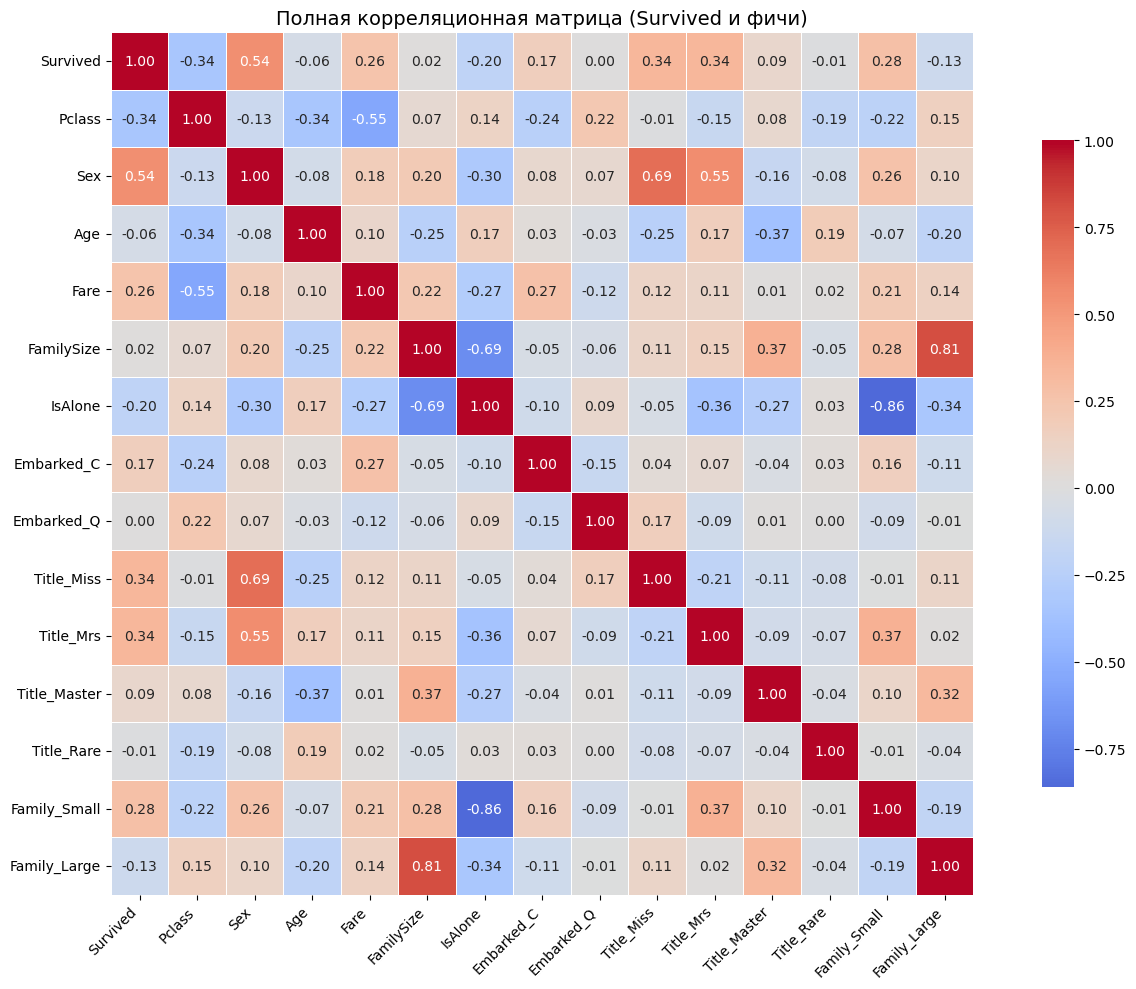

In [37]:
# Расчет корреляционной матрицы
corr_matrix = df.corr()

# Построение полной тепловой карты
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})
plt.title("Полная корреляционная матрица (Survived и фичи)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1. __Пол (Sex)__ имеет самую высокую корреляцию с выживаемостью (около +0.54). Положительный знак указывает, что значение Sex=1 (женщины) ассоциировано с повышенным шансом выжить. Это отражает правило "women and children first" – женщины выживали значительно чаще мужчин (для справки: в данном наборе ~74% женщин выжили против ~19% мужчин).

2. __Титулы Miss и Mrs__ тоже сильно положительно коррелируют с выживаемостью (~+0.33). Эти титулы принадлежат женщинам (незамужним и замужним соответственно), поэтому неудивительно, что они связаны с большим шансом спастись. Небольшая положительная корреляция видна и у титула Master (+0.09) – так обозначались мальчики, дети мужского пола, которых также спасали чаще, чем взрослых мужчин. Категория Rare имеет корреляцию, близкую к 0 (разнородная группа случаев, общий эффект неявный).

3. __Pclass (класс)__ заметно отрицательно коррелирует с выживаемостью (~–0.34). Пассажиры 3-го класса (более высокое числовое значение Pclass) выживали значительно реже, чем пассажиры 1-го класса. Таким образом, чем выше социальный статус и класс каюты, тем больше шанс выжить.

4. Размер семьи тоже влияет на результат: наличие небольшой семьи (Family_Small) показывает положительную корреляцию с выживаемостью (+0.28), тогда как большие семьи (Family_Large) коррелируют отрицательно (–0.13). Это может отражать, что пассажирам с 2-4 родственниками было чуть легче выжить (может, они помогали друг другу), а вот очень большие семьи спастись не успевали. Интересно, что IsAlone (путешествовал один) имеет отрицательную корреляцию (~–0.20), то есть одиночки выживали хуже, чем те, кто был с семьёй – что согласуется с интуицией (впрочем, разница не столь велика).

5. __Fare (стоимость билета)__ показывает умеренно положительную связь с выживаемостью (+0.26). Дорогой билет означает лучшую каюту/класс обслуживания, что повышало шансы спасения. При этом Age (возраст) имеет слабую отрицательную корреляцию (–0.08): молодые пассажиры выживали немного чаще пожилых, однако эта линейная связь не очень сильна.

6. __Embarked (порт):__ видно, что порт Cherbourg (Embarked_C) имеет положительную корреляцию с выживаемостью (~+0.17), что исторически обусловлено тем, что в Шербуре село много пассажиров 1-го класса. Порт Queenstown (Embarked_Q) практически не связан с выживаемостью (корреляция около 0).

__Вывод:__ В целом, корреляционный анализ показывает разумность созданных признаков: они действительно связаны с шансами на выживание и дополняют исходные данные (пол, класс, стоимость) дополнительной информацией (социальный статус через титул, структура семьи и т.д.).

## 3.5 Построение простой модели и оценка точности

Построим простую модель классификации, чтобы проверить, насколько новые признаки улучшают предсказание выживаемости. Возьмём логистическую регрессию, поскольку она интерпретируема и подходит для бинарного целевого признака. Разобьём данные на обучение и тест (например, 80% тренировочных данных и 20% на проверку), обучим модель и измерим точность (accuracy) на тестовой части.

In [39]:
# Разделение признаков и целевого столбца
X = df.drop('Survived', axis=1)
y = df['Survived']

# Разбиение на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Обучение логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Предсказание и оценка точности на тесте
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {acc:.3f}")

Accuracy on test set: 0.844


Модель логистической регрессии правильно классифицирует ~84.4% пассажиров на тестовой выборке. Это весьма высокая точность для данной задачи, существенно выше чем базовое угадывание. Для сравнения, если бы мы просто предсказывали всех пассажиров как погибших (что дало бы ~61.6% верных ответов, поскольку ~38% выжило), точность была бы ~0.616. Наша модель с инженерией признаков превосходит этот базовый уровень.

## 3.7 Заключение

Произведённый Feature Engineering заметно обогатил информацию о пассажирах. Новые признаки (титул, характеристики семьи) оказались важными: они улучшили понимание модели о каждом пассажире и позволили достичь высокой точности ~84% на тесте с простой логистической моделью. Анализ коэффициентов подтвердил известные закономерности гибели Titanic: женщины и дети имели значительно больший шанс спастись, пассажиры 1-го класса тоже выигрывали в выживании, а вот мужчины, особенно из 3-го класса или с большими семьями, были в группе риска. Таким образом, этап инженерии признаков был успешно выполнен: мы создали осмысленные признаки, убедились в их корреляции с результатом и увидели, как модель их использует для прогнозирования выживаемости пассажиров.

In [40]:
# Сохранение обработанного датасета в папку "datasets":
df.to_csv(r'./datasets/feature_titanic_dataset.csv', index=False)